In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os.path
from os import path

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
root_path = ""
data_path = ""

for creds_path in creds_path_ar:
  if path.exists(creds_path):
      config_parser = configparser.ConfigParser()
      config_parser.read(creds_path)
      root_path = config_parser['MAIN']["PATH_ROOT"]
      data_path = config_parser['MAIN']["PATH_DATA"]
      WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
      ENV = config_parser['MAIN']["ENV"]
      break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
cd {root_path}

/content/gdrive/My Drive/WORK/ML/develop/MAFAT/sota-mafat-radar


In [4]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.utils import experiment_utils as utils
from src.utils import boilerplate

from src.model_arch import arch_setup
from src.model_arch import base_base_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [5]:
train_x, train_y, val_x, val_y = boilerplate.classic_trainval(data_path)

Everything is setup correctly


## Implementation

In [6]:
train_set = arch_setup.DS(train_x,train_y)
val_set= arch_setup.DS(val_x,val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 16, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 16, shuffle = True, num_workers = 2)

In [7]:
def init_weights(m):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [8]:
model= base_base_model.base_base_model()
model.apply(init_weights)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#TODO: implement the Glorot Normal
# init = tf.keras.initializers.GlorotNormal(seed = 0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
model.to(device)

base_base_model(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5760, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [10]:
arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 10,train_y=train_y,val_y=val_y)

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch : 0.0000
loss : 0.0258
auc : 0.4986
acc : 0.8499
val_loss : 0.0753
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch : 1.0000
loss : 0.0251
auc : 0.5000
acc : 0.8523
val_loss : 0.0686
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 3
epoch : 2.0000
loss : 0.0249
auc : 0.5000
acc : 0.8523
val_loss : 0.0569
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 4
epoch : 3.0000
loss : 0.0248
auc : 0.5000
acc : 0.8523
val_loss : 0.0684
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 5
epoch : 4.0000
loss : 0.0248
auc : 0.5000
acc : 0.8523
val_loss : 0.0650
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 6
epoch : 5.0000
loss : 0.0247
auc : 0.5000
acc : 0.8523
val_loss : 0.0610
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 7
epoch : 6.0000
loss : 0.0246
auc : 0.5000
acc : 0.8523
val_loss : 0.0609
val_auc : 0.5000
val_acc : 0.5146

---------------------------

started training epoch no. 8
epoc

[{'acc': 0.8498781973203411,
  'auc': 0.4985709181850661,
  'epoch': 0,
  'loss': 0.02577684702942699,
  'val_acc': 0.5145631067961165,
  'val_auc': 0.5,
  'val_loss': 0.07528667291777033},
 {'acc': 0.8523142509135201,
  'auc': 0.5,
  'epoch': 1,
  'loss': 0.02511225926636488,
  'val_acc': 0.5145631067961165,
  'val_auc': 0.5,
  'val_loss': 0.06864083150829697},
 {'acc': 0.8523142509135201,
  'auc': 0.5,
  'epoch': 2,
  'loss': 0.024871480356262098,
  'val_acc': 0.5145631067961165,
  'val_auc': 0.5,
  'val_loss': 0.05692617464991449},
 {'acc': 0.8523142509135201,
  'auc': 0.5,
  'epoch': 3,
  'loss': 0.024756980113839405,
  'val_acc': 0.5145631067961165,
  'val_auc': 0.5,
  'val_loss': 0.06838150510510195},
 {'acc': 0.8523142509135201,
  'auc': 0.5,
  'epoch': 4,
  'loss': 0.024770816485199004,
  'val_acc': 0.5145631067961165,
  'val_auc': 0.5,
  'val_loss': 0.06501444296543653},
 {'acc': 0.8523142509135201,
  'auc': 0.5,
  'epoch': 5,
  'loss': 0.024662322180978635,
  'val_acc': 0.514

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


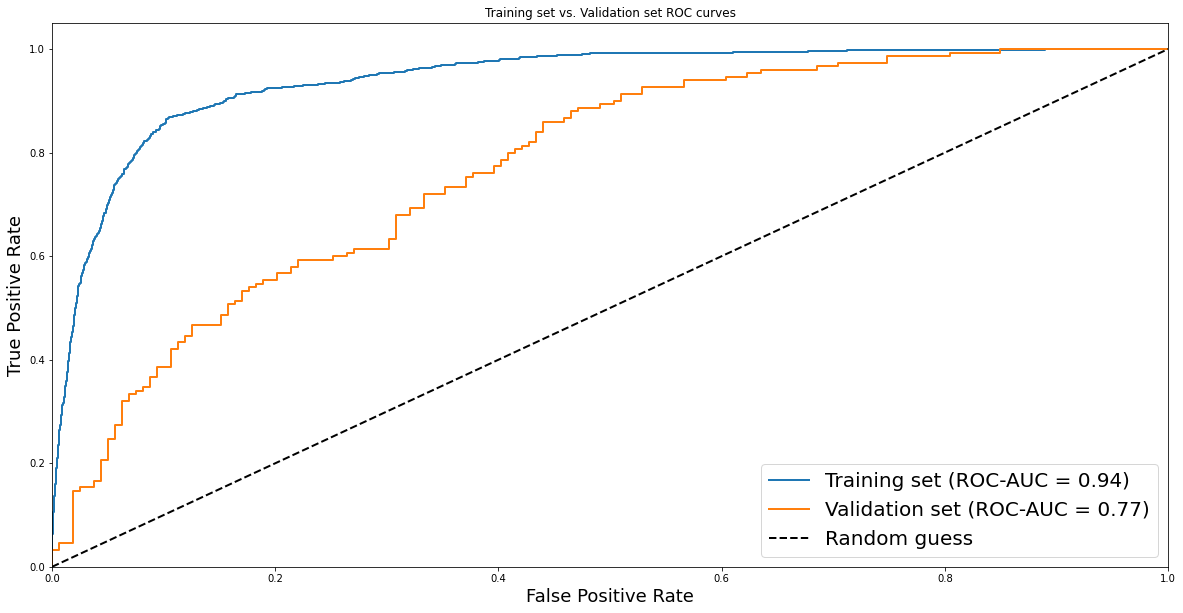

In [11]:
pred = [model(torch.from_numpy(train_x).to(device, dtype=torch.float)).detach().cpu().numpy(),
        model(torch.from_numpy(val_x).to(device, dtype=torch.float)).detach().cpu().numpy()]
actual = [train_y, val_y]
utils.stats(pred, actual)

In [43]:
pred[0].detach().cpu().numpy()

array([[0.11206806],
       [0.12878144],
       [0.14102888],
       ...,
       [0.1382539 ],
       [0.131481  ],
       [0.11310157]], dtype=float32)